# Non-negative Matrix Factorization (NMF)

Supongamos que los vectores columna de una matriz $X \geq 0$ se pueden escribir como combinación lineal de los vectores columna de una matriz $D\geq0$. Es decir, existe una matriz $\Lambda\geq0$ tal que 
$X = D\Lambda$.

La idea es que la dimensión de los factores puede ser mucho menor a la de el producto $X$.

### Ejemplo:
- $X_{10,000\times500}$ matriz representando 500 documentos indexados con 10,000 palabras. 
- Queremos una matriz de features $D_{10,000\times10}$ y una matriz de coeficientes $\Lambda_{10\times500}$
- Cada uno de los 500 documentos originales queda representado como una combinación lineal de features ocultos $D$ ($X \simeq D\Lambda$).
![title](nmf_matrix.png)
### Minimización del error

\begin{equation}
\min_{D,\,\Lambda} d(X,D\Lambda), \quad \text{sujeto a } D \geq 0, \; \Lambda \geq 0 
\end{equation}

- La distancia $b$ se toma usualmente como la norma Frobenius entre matrices
- Extensión de la divergencia de Kullback-Leibler (asumiendo que las columnas x_i están normalizadas)
\begin{equation}
D_{KL}(X||\hat{X}) = - \sum_{i} D_{KL}(x_i||\hat{x_i}) =   - \sum_{ij} x_{ij} \log \frac{x_{ij}}{\hat{x}_{ij}}
\end{equation}

### Aplicaciones
- Análisis de tópicos
- Segmentación de imágenes
- Reducción de dimensión
- Clustering
- Sistemas de recomendación

# Distancia de Wasserstein
### Transporte óptimo (Earth Mover's Distance)
![Earth Mover's Distance](earth_move.png)
\begin{equation}
\mathrm{W}(P_r, P_\theta) = \inf_{\gamma \in \Pi} \, \sum\limits_{x,y} \Vert x - y \Vert \gamma (x,y) = \inf_{\gamma \in \Pi} \ \mathbb{E}_{(x,y) \sim \gamma} \Vert x - y \Vert
\end{equation}

- $\gamma(x,y)$ representa la cantidad de masa que se mueve de $x$ a $y$.
- $\Pi$ es el conjunto de todos los caminos $\gamma$ que transforman la distribución $P_r$ en $P_\theta$.
- El camino óptimo $\gamma^*$ se puede encontrar planteando un problema de programación lineal.

# Ejemplo básico

### Generación de datos

In [1]:
import numpy as np
from matplotlib import pyplot as plt

ndata=100;              # number of mixtures
sample_size=10000;        # number of sample for each mixture
bins=100;        # number of histogram bins

minVal=-12;
maxVal=12;
x=np.linspace(minVal,maxVal,bins); # value of the histograms bins

In [2]:
mu = [-6,0,6]                             # mean values for the Gaussians means
shiftVariance = 2*np.eye(3)               # variance of the Gaussians means
mean = np.random.multivariate_normal(mu, shiftVariance,ndata)     # generate the gaussian means

weights = np.random.uniform(size=(3,ndata))     # generate the mixture weights

sigma = 1;                                # variance of the Gaussians

data = np.zeros((ndata, sample_size))

In [3]:
for i in range(ndata):
    s1 = np.random.normal(mean[i,0], sigma, sample_size)
    s2 = np.random.normal(mean[i,1], sigma, sample_size)
    s3 = np.random.normal(mean[i,2], sigma, sample_size)
    w1 = np.repeat(weights[0,i],sample_size)
    w2 = np.repeat(weights[1,i],sample_size)
    w3 = np.repeat(weights[2,i],sample_size)
    data[:,i], _ = np.histogram(np.r_[s1,s2,s3], bins=bins,
                                weights = np.r_[w1,w2,w3],
                                range=(minVal,maxVal),
                                density=True)

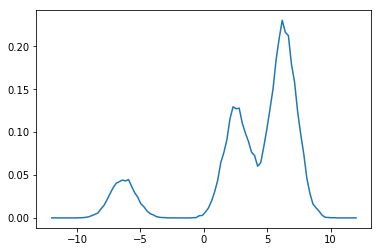

In [9]:
plt.plot(x,data[:,5])
plt.show()

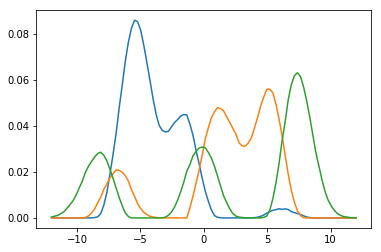

In [8]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0,
           beta_loss='kullback-leibler', solver='mu')
D = model.fit_transform(data)
H = model.components_
plt.plot(x, D)
plt.show()

In [6]:
from scipy.stats import wasserstein_distance as wd

### Wasserstein NMF
![title](w_nmf.png)

- Kullback-Leibler no captura la métrica de $\mathbb{R}$. 
- El cálculo de la distancia de Wasserstein es muy costoso.
- El artículo propone una forma de hacer el cálculo mucho más eficiente.

### Problema de transporte óptimo 
- $\Sigma_s := $ conjunto de histogramas s-dimensionales.
- $p \in \Sigma_n, \; q \in \Sigma_s$ 

\begin{equation} 
U(p,q) = \left\lbrace 
T \in  \mathbb{R}_+^{n\times s} \left \lvert
\begin{split}
T\mathbb{1} = p \\
T^T\mathbb{1}=q
\end{split}
\right.\right\rbrace
\end{equation}

\begin{equation}
W(p,q) = \min_{T \in U(p,q)} \langle M, T \rangle
\end{equation}


### Distancia de Wasserstein regularizada
- La distancia de Wasserstein no es una función suave de sus argumentos.
- Se suaviza el problema de transporte óptimo con un término de entropía 

\begin{equation} \label{w_reg}
W_\gamma(p,q) = min_{T\in U(p,q)} \langle M,T \rangle + 
\gamma \langle T, \log T \rangle
\end{equation}

- A diferencia de $W$, $W_\gamma$ es diferenciable y el problema de minimización tiene una solución única. 
- El cálculo de $W_\gamma$ se puede hacer de manera eficiente con un algoritmo que converge linealmente y cada paso tiene un costo de $\mathcal{O}(ns)$.

### Conjugada convexa (Legendre-Fechel) y teoremas de dualidad
- Para $p \in \Sigma_n$ fijo se define la función

\begin{equation}
H_p := q \mapsto W_\gamma(p,q)
\end{equation}

- La conjugado convexa de $H_p$ y su gradiente se pueden calcular de manera explícita. 

- El problema se reduce a lo siguiente:

\begin{equation} 
\min_{\Lambda \in \mathbb{R}^{k\times m},\; D \in \mathbb{R}^{s \times k}}
\sum_{i=1}^m H_{x_i} (D \lambda_i)
\end{equation}
tal que $D\Lambda \in \Sigma_s^m$.

- Se separa el problema minimizando para $D$ y $\Lambda$ independientemente

\begin{equation} 
\min_{\Lambda \in \mathbb{R}^{k\times m}}
\sum_{i=1}^m H_{x_i} (D \lambda_i)
\end{equation}

- La solución $\Lambda^{*}$ satisface:

\begin{equation} 
D\lambda^*_i = \nabla H^*_{x_i}(g^*_i), 
\end{equation}
donde
\begin{equation} 
g^*_i \in \text{argmin}_{g \in \mathbb{R}^s}\, H^*_{x_i}(g^*_i), \; D^T g = 0.  
\end{equation}

- De manera similar se puede minizar 

\begin{equation} 
\min_{D \in \mathbb{R}^{s\times k}}
\sum_{i=1}^m H_{x_i} (D \lambda_i)
\end{equation}

utilizando un problema dual.

### Resultados
![title](performance.png)
![title](wordcloud.png)